In [2]:



import numpy as np
import tensorflow as tf
from tensorflow import keras
#import pandas as pd
from numpy.random import uniform, lognormal, normal
import astropy
from astropy.modeling.models import Sersic2D
import matplotlib.pyplot as plt 
from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth


In [3]:
def make_galaxy_parameters(n_images=300, n_gal_per_image=1,
                         img_size=(64,64), seed = 12345, plot = True):
    n_gals = (n_gal_per_image, n_images)
    np.random.seed(seed)
    params = dict(
        amplitude = lognormal(0, 0.1, size=n_gals),
        r_eff = lognormal(2, 0.1, size=n_gals),
        n = lognormal(0.5, 0.2, size=n_gals),
        ellip = uniform(0.0, 0.8, size=n_gals),
        x_0 = normal(0.5, 0.1, size=n_gals) * img_size[0],
        y_0 = normal(0.5, 0.1, size=n_gals) * img_size[1],
        theta = uniform(0.0, np.pi, size=n_gals)
    )
    return params

In [4]:
def make_centered_galaxy_parameters(n_images=3000, n_gal_per_image=1,
                         img_size=(64,64), seed = 25356, plot = True):
    n_gals = (n_gal_per_image, n_images)
    np.random.seed(seed)
    centered_params = dict(
        amplitude = lognormal(0, 0.1, size=n_gals),
        r_eff = lognormal(2, 0.1, size=n_gals),
        n = lognormal(0.5, 0.2, size=n_gals),
        ellip = uniform(0.0, 0.8, size=n_gals),
        x_0 =  np.full(n_gals, img_size[0]/2, dtype = int),
        y_0 = np.full(n_gals, img_size[1]/2, dtype = int),
        theta = uniform(0.0, np.pi, size=n_gals)
    )
    return centered_params

In [5]:
def make_blended_gals(params, centered_params, ngal = 30000, img_size=(64, 64)):
    x, y = np.mgrid[:img_size[1], :img_size[0]]
    shape = (2, ngal)
    # Shape = (ngal, n_components)
    components = np.zeros(shape + img_size[::-1])
    blended = np.zeros(shape[1:] + img_size[::-1])
    for img_idx in range(shape[1]):
        centered_par = {p: x[0, img_idx] for p, x in centered_params.items()}
        centered_mod = Sersic2D(**centered_par)(y, x)
        components[0, img_idx] = centered_mod
        blended[img_idx] += centered_mod
        par = {p: x[0, img_idx] for p, x in params.items()}
        mod = Sersic2D(**par)(y, x)
        components[1, img_idx] = mod 
        blended[img_idx] += mod
    return components, blended

In [6]:
def add_noise(img, scale=0.01):
    return img + normal(scale=scale, size=img.shape)

In [7]:
def asinh_scale(x, a=0.1, inverse=False):
    # This is a common way of scaling astronomical images
    # so that inner and outer regions of galaxies can be seen
    return np.arcsinh(x / a) / np.arcsinh(1 / a)

In [8]:

ngal = 350
ncomp = 1

params = make_galaxy_parameters(ngal, plot=False)
centered_params = make_centered_galaxy_parameters(ngal, plot=False)

components, blended = make_blended_gals(params, centered_params, ngal)

blended = add_noise(blended)
components = add_noise(components)

components = asinh_scale(components)
blended = asinh_scale(blended)

In [9]:

blended.shape, components.shape

((350, 64, 64), (2, 350, 64, 64))

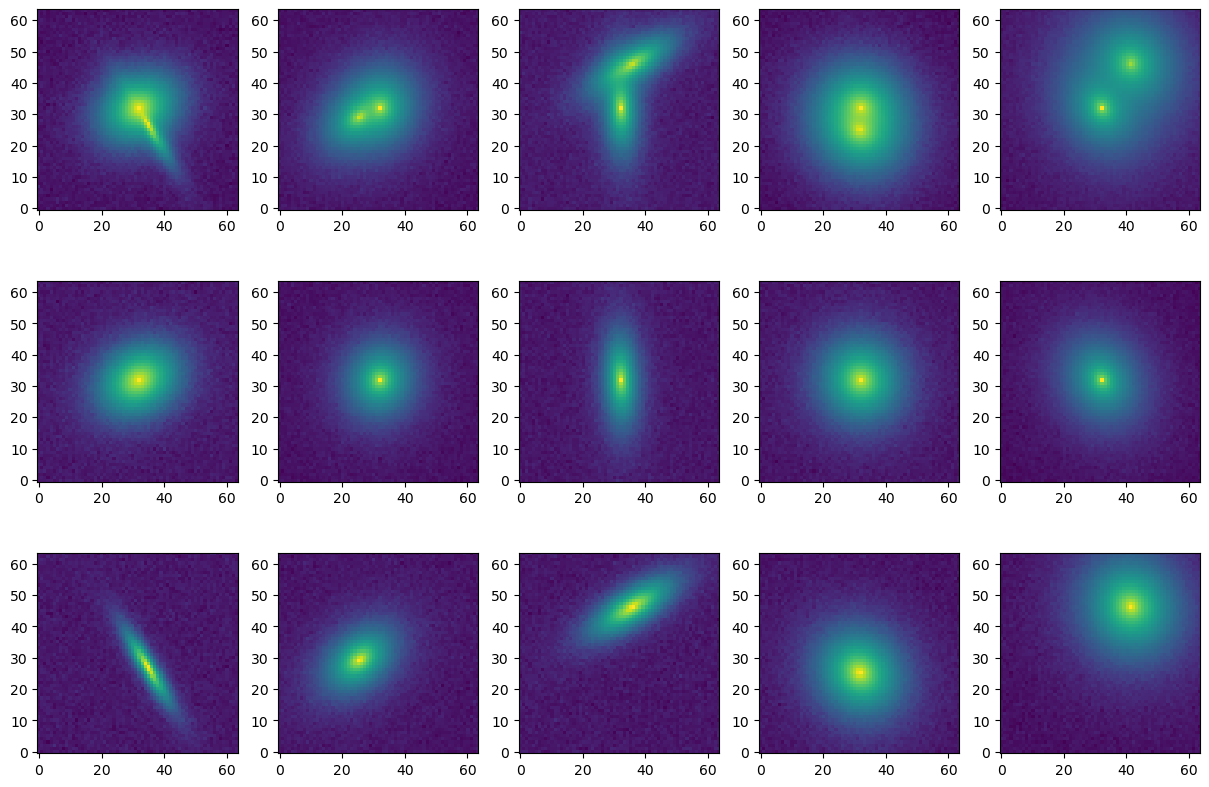

In [10]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(blended[i], origin='lower', interpolation='nearest')
    for j in range(2):
        ax[j + 1, i].imshow(components[j, i], origin='lower', interpolation='nearest') 

In [11]:
np.save("central_blends.npy", blended)
np.save("central_components.npy", components)